In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import boto3

In [47]:
cfn = boto3.client('cloudformation')
response = cfn.describe_stacks(StackName='SageMakerRedshift')['Stacks'][0]

In [65]:
db_user = ''
db_name = ''
db_port = 5439

cluster_endpoint = ''
cluster_name = ''

redshift_role = '<your_redshift_role>'

In [66]:
for item in response['Parameters']:
    if item['ParameterKey'] == 'MasterUsername':
        db_user = item['ParameterValue']
    elif item['ParameterKey'] == 'DatabaseName':
        db_name = item['ParameterValue']
    elif item['ParameterKey'] == 'PortNumber':
        db_port = item['ParameterValue']

In [67]:
for item in response['Outputs']:
    if item['OutputKey'] == 'ClusterEndpoint':
        cluster_endpoint = item['OutputValue'].split(':')[0]
    elif item['OutputKey'] == 'ClusterName':
        cluster_name = item['OutputValue']

In [104]:
# get temporal cluster credentials
redshift = boto3.client('redshift')
credentials = redshift.get_cluster_credentials(
    DbUser=user_name, 
    DbName=db_name, 
    ClusterIdentifier=cluster_name, 
    DurationSeconds=3600,
    AutoCreate=False
)

In [142]:
# connect to Redshift
con = psycopg2.connect(
    host=cluster_endpoint, 
    port=db_port, 
    dbname=db_name, 
    user=credentials['DbUser'], 
    password=credentials['DbPassword']
)

https://docs.aws.amazon.com/ja_jp/redshift/latest/gsg/rs-gsg-create-sample-db.html

In [143]:
sql_create_table = ["""
create table users(
	userid integer not null distkey sortkey,
	username char(8),
	firstname varchar(30),
	lastname varchar(30),
	city varchar(30),
	state char(2),
	email varchar(100),
	phone char(14),
	likesports boolean,
	liketheatre boolean,
	likeconcerts boolean,
	likejazz boolean,
	likeclassical boolean,
	likeopera boolean,
	likerock boolean,
	likevegas boolean,
	likebroadway boolean,
	likemusicals boolean);
""", 
"""
create table venue(
	venueid smallint not null distkey sortkey,
	venuename varchar(100),
	venuecity varchar(30),
	venuestate char(2),
	venueseats integer);
""", 
"""
create table category(
	catid smallint not null distkey sortkey,
	catgroup varchar(10),
	catname varchar(10),
	catdesc varchar(50));
""", 
"""
create table date(
	dateid smallint not null distkey sortkey,
	caldate date not null,
	day character(3) not null,
	week smallint not null,
	month character(5) not null,
	qtr character(5) not null,
	year smallint not null,
	holiday boolean default('N'));
""", 
"""
create table event(
	eventid integer not null distkey,
	venueid smallint not null,
	catid smallint not null,
	dateid smallint not null sortkey,
	eventname varchar(200),
	starttime timestamp);
""", 
"""
create table listing(
	listid integer not null distkey,
	sellerid integer not null,
	eventid integer not null,
	dateid smallint not null  sortkey,
	numtickets smallint not null,
	priceperticket decimal(8,2),
	totalprice decimal(8,2),
	listtime timestamp);
""", 
"""
create table sales(
	salesid integer not null,
	listid integer not null distkey,
	sellerid integer not null,
	buyerid integer not null,
	eventid integer not null,
	dateid smallint not null sortkey,
	qtysold smallint not null,
	pricepaid decimal(8,2),
	commission decimal(8,2),
	saletime timestamp);
"""]

In [144]:
for sql in sql_create_table:
    with con.cursor() as cur:
        cur.execute(sql)

In [145]:
sql_copy=["""
copy users from 's3://awssampledbuswest2/tickit/allusers_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';
""", 
"""
copy venue from 's3://awssampledbuswest2/tickit/venue_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';
""", 
"""
copy category from 's3://awssampledbuswest2/tickit/category_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';
""", 
"""
copy date from 's3://awssampledbuswest2/tickit/date2008_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';
""", 
"""
copy event from 's3://awssampledbuswest2/tickit/allevents_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' timeformat 'YYYY-MM-DD HH:MI:SS' region 'us-west-2';
""", 
"""
copy listing from 's3://awssampledbuswest2/tickit/listings_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';
""", 
"""
copy sales from 's3://awssampledbuswest2/tickit/sales_tab.txt'
credentials 'aws_iam_role={}'
delimiter '\t' timeformat 'MM/DD/YYYY HH:MI:SS' region 'us-west-2';
"""]

In [146]:
%%time
for sql in sql_copy:
    with con.cursor() as cur:
        cur.execute(sql.format(redshift_role))
        print('Done: ', sql)

Done:  
copy users from 's3://awssampledbuswest2/tickit/allusers_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';

Done:  
copy venue from 's3://awssampledbuswest2/tickit/venue_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';

Done:  
copy category from 's3://awssampledbuswest2/tickit/category_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';

Done:  
copy date from 's3://awssampledbuswest2/tickit/date2008_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';

Done:  
copy event from 's3://awssampledbuswest2/tickit/allevents_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' timeformat 'YYYY-MM-DD HH:MI:SS' region 'us-west-2';

Done:  
copy listing from 's3://awssampledbuswest2/tickit/listings_pipe.txt' 
credentials 'aws_iam_role={}' 
delimiter '|' region 'us-west-2';

Done:  
copy sales from 's3://awssampledbuswest2/tickit/sales_tab.txt'
credentials 'aws_iam_role={}'
delimiter '	

In [147]:
# Get definition for the sales table.
sql="""
SELECT *    
FROM pg_table_def    
WHERE tablename = 'sales';
"""
%time pd.read_sql(sql=sql, con=con)

CPU times: user 66 ms, sys: 8.7 ms, total: 74.7 ms
Wall time: 559 ms


,schemaname,tablename,column,type,encoding,distkey,sortkey,notnull
0,public,sales,salesid,integer,delta32k,False,0,True
1,public,sales,listid,integer,delta32k,True,0,True
2,public,sales,sellerid,integer,delta32k,False,0,True
3,public,sales,buyerid,integer,delta32k,False,0,True
4,public,sales,eventid,integer,delta32k,False,0,True
5,public,sales,dateid,smallint,lzo,False,1,True
6,public,sales,qtysold,smallint,lzo,False,0,True
7,public,sales,pricepaid,"numeric(8,2)",lzo,False,0,False
8,public,sales,commission,"numeric(8,2)",delta32k,False,0,False
9,public,sales,saletime,timestamp without time zone,lzo,False,0,False


In [148]:
# Find total sales on a given calendar date.
sql="""
SELECT sum(qtysold) 
FROM   sales, date 
WHERE  sales.dateid = date.dateid 
AND    caldate = '2008-01-05';
"""
%time pd.read_sql(sql=sql, con=con)

CPU times: user 2.04 ms, sys: 147 µs, total: 2.19 ms
Wall time: 5.33 s


,sum
0,210


In [149]:
# Find top 10 buyers by quantity.
sql="""
SELECT firstname, lastname, total_quantity 
FROM   (SELECT buyerid, sum(qtysold) total_quantity
        FROM  sales
        GROUP BY buyerid
        ORDER BY total_quantity desc limit 10) Q, users
WHERE Q.buyerid = userid
ORDER BY Q.total_quantity desc;
"""
%time df = pd.read_sql(sql=sql, con=con)
df.shape

CPU times: user 2.83 ms, sys: 0 ns, total: 2.83 ms
Wall time: 9.45 s


(10, 3)

In [150]:
df

,firstname,lastname,total_quantity
0,Jerry,Nichols,67
1,Kameko,Bowman,64
2,Armando,Lopez,64
3,Kellie,Savage,63
4,Herrod,Sparks,60
5,Rhona,Sweet,60
6,Kadeem,Blair,60
7,Belle,Foreman,60
8,Deborah,Barber,60
9,Penelope,Merritt,60


In [151]:
# Find events in the 99.9 percentile in terms of all time gross sales.
sql="""
SELECT eventname, total_price 
FROM  (SELECT eventid, total_price, ntile(1000) over(order by total_price desc) as percentile 
       FROM (SELECT eventid, sum(pricepaid) total_price
             FROM   sales
             GROUP BY eventid)) Q, event E
       WHERE Q.eventid = E.eventid
       AND percentile = 1
ORDER BY total_price desc;
"""
%time df = pd.read_sql(sql=sql, con=con)
df.shape

CPU times: user 3.04 ms, sys: 0 ns, total: 3.04 ms
Wall time: 10.6 s


(9, 2)

In [152]:
df.head()

,eventname,total_price
0,Adriana Lecouvreur,51846.0
1,Janet Jackson,51049.0
2,Phantom of the Opera,50301.0
3,The Little Mermaid,49956.0
4,Citizen Cope,49823.0


Text(0,0.5,'Histogram')

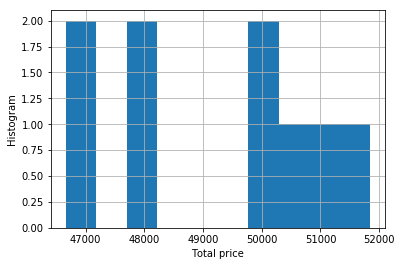

In [153]:
df.total_price.hist()
plt.xlabel('Total price')
plt.ylabel('Histogram')